In [1]:
import os
import shutil
import cv2
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
ORIGINAL_DATA_DIR = './data/airbus-ship-detection'
NEW_DATA_DIR = './data/airbus-ships-data'
IMGS_TRAIN_DIR = 'train_v2'

In [3]:
df = pd.read_csv(os.path.join(ORIGINAL_DATA_DIR, 'train_ship_segmentations_v2.csv'))

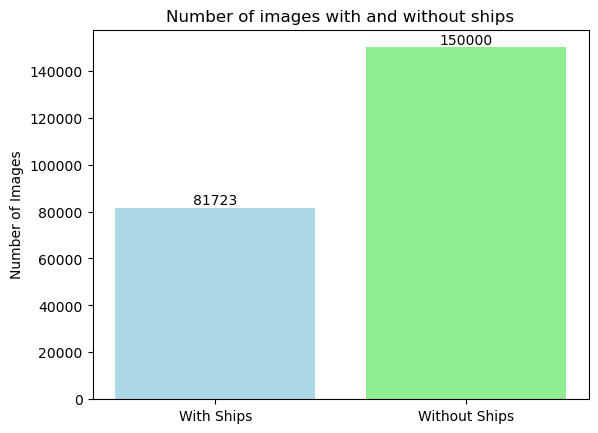

In [6]:
# Assuming 'EncodedPixels' is NaN for images without ships, and non-NaN for images with ships
num_images_with_ships = df['EncodedPixels'].notna().sum()
num_images_without_ships = df['EncodedPixels'].isna().sum()

# Data to plot
labels = ['With Ships', 'Without Ships']
sizes = [num_images_with_ships, num_images_without_ships]
colors = ['lightblue', 'lightgreen']

# Plot
fig, ax = plt.subplots()
ax.bar(labels, sizes, color=colors)

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Images')
ax.set_title('Number of images with and without ships')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)

# Attach a text label above each bar, displaying its height
for i in range(len(sizes)):
    ax.text(i, sizes[i], str(sizes[i]), ha='center', va='bottom')

plt.show()

#### Dataset contains significantly more images without ships than with ships, the model may become biased towards predicting 'no ship' since that would be correct most of the time.Having a disproportionately large number of images without ships can make training inefficient. It will take longer and consume more computational resources without necessarily improving the model's ability to detect ships. So i will take only 30000 random images without ships.

## Creation of train and test datasets

In [4]:
zero_ships_imgs = df[df['EncodedPixels'].isna()]

In [5]:
zero_ships_imgs.shape

(150000, 2)

#### Sample 30,000 random rows from the DataFrame with NaN values(images without ships)

In [6]:
imgs_without_ships = zero_ships_imgs.sample(n=30000, random_state=1)
imgs_with_ships = df.dropna(subset=['EncodedPixels'])
df = pd.concat([imgs_without_ships, imgs_with_ships])

In [7]:
df = df.sample(frac=1).reset_index(drop=True)
df.shape

(111723, 2)

In [8]:
df.to_csv(os.path.join(NEW_DATA_DIR, 'rle_encodings.csv'), index=False)

#### Splitting data

In [9]:
df_unique = df.drop_duplicates(subset='ImageId', keep='first')
df_train, df_test = train_test_split(df_unique, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=42)

In [10]:
print(f"Train dataset: shape: {df_train.shape}, nan: {df_train['EncodedPixels'].isna().sum()}")
print(f"Validation dataset: shape: {df_val.shape}, nan: {df_val['EncodedPixels'].isna().sum()}")
print(f"Test dataset: shape: {df_test.shape}, nan: {df_test['EncodedPixels'].isna().sum()}")

Train dataset: shape: (52239, 2), nan: 21595
Validation dataset: shape: (5805, 2), nan: 2433
Test dataset: shape: (14512, 2), nan: 5972


#### Create folders with sampled train and test images

In [11]:
df_test.shape

(12512, 2)

In [11]:
def create_img_dir(df, original_dir, new_dir):
    errors = 0
    os.makedirs(new_dir, exist_ok=True)
    
    for file_name in df['ImageId']:
        source_file = os.path.join(original_dir, file_name)
        destination_file = os.path.join(new_dir, file_name)

        # Check if the source file exists and then copy it
        if os.path.exists(source_file):
            shutil.copy(source_file, destination_file)
        else:
            errors += 1
            print(f"File not found: {source_file}")

    if errors == 0:
        print("~"*30)
        print("FILES COPIED SUCCESSFULLY")
        print("~"*30)
    else:
        print("~"*30)
        print(f"FILES COPIED WITH {errors} errors")
        print("~"*30)

In [12]:
new_train_dir = os.path.join(NEW_DATA_DIR, 'train_images')
new_val_dir = os.path.join(NEW_DATA_DIR, 'val_images')
new_test_dir = os.path.join(NEW_DATA_DIR, 'test_images')
original_train_dir = os.path.join(ORIGINAL_DATA_DIR, IMGS_TRAIN_DIR)

create_img_dir(df_train, original_train_dir, new_train_dir)
create_img_dir(df_val, original_train_dir, new_val_dir)
create_img_dir(df_test, original_train_dir, new_test_dir)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
FILES COPIED SUCCESSFULLY
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
FILES COPIED SUCCESSFULLY
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
FILES COPIED SUCCESSFULLY
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


## Data leak check

In [13]:
counter = df_train["ImageId"].isin(df_test["ImageId"]).sum()

In [14]:
counter

0

## Mask creation

In [20]:
def rle_to_mask(rle_string, shape):
    s = rle_string.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to the original image


def combine_masks(rle_list, shape):
    # Combine multiple RLEs into one mask
    combined_mask = np.zeros(shape, dtype=np.uint8)
    for rle in rle_list:
        if isinstance(rle, str):  # Check if RLE is valid (not NaN or similar)
            mask = rle_to_mask(rle, shape)
            combined_mask = np.maximum(combined_mask, mask)
    return combined_mask

#### Example of mask combination

In [38]:
img_path1 = os.path.join(NEW_DATA_DIR, "train_images", "0a3b48a9c.jpg")
img_path2 = os.path.join(NEW_DATA_DIR, "val_images", "0ba29cbcf.jpg")

In [39]:
df1 = df.set_index("ImageId")

In [40]:
code1 = df1.loc["0a3b48a9c.jpg"]["EncodedPixels"]
code2 = df1.loc["0ba29cbcf.jpg"]["EncodedPixels"] 

In [41]:
mask1 = combine_masks(code1, (768, 768))
mask2 = combine_masks(code2, (768, 768))

image1 = mpimg.imread(img_path1)
image2 = mpimg.imread(img_path2)

images = [mask1, image1, mask2, image2]

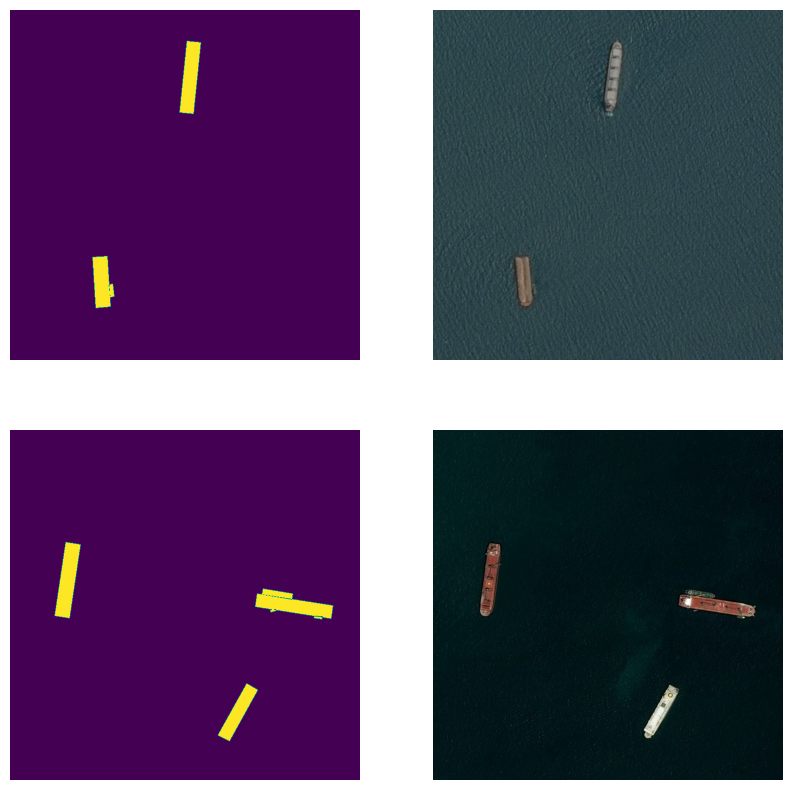

In [42]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for ax, image in zip(axs, images):
    ax.imshow(image)
    ax.axis('off')

#### Creation of masks

In [43]:
train_masks_folder = os.path.join(NEW_DATA_DIR, "train_masks")
val_masks_folder = os.path.join(NEW_DATA_DIR, "val_masks")
test_masks_folder = os.path.join(NEW_DATA_DIR, "test_masks")

In [44]:
def create_masks(df, img_dir, masks_dir):
    os.makedirs(masks_dir, exist_ok=True)
    df = df.set_index("ImageId")
    for file_name in os.listdir(img_dir):
        rle = df.loc[file_name, 'EncodedPixels']
        if isinstance(rle, pd.Series):
            rle = rle.tolist()
        else:
            rle = [rle]
                
        mask = combine_masks(rle, (768, 768))
        mask_image = Image.fromarray(mask.astype(np.uint8) * 255)
        mask_image_path = os.path.join(masks_dir, f"{os.path.splitext(file_name)[0]}.png")
        mask_image.save(mask_image_path)

In [45]:
create_masks(df, os.path.join(NEW_DATA_DIR, "train_images"), train_masks_folder)
create_masks(df, os.path.join(NEW_DATA_DIR, "val_images"), val_masks_folder)
create_masks(df, os.path.join(NEW_DATA_DIR, "test_images"), test_masks_folder)

#### Mask check

In [46]:
img_title = "0a99243c0"
mask_path = os.path.join(train_masks_folder, img_title + ".png")
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
mask = mask / 255
mask = mask.astype(np.float32)

In [47]:
img_path = os.path.join(NEW_DATA_DIR, "train_images", img_title + ".jpg")
image = cv2.imread(img_path)

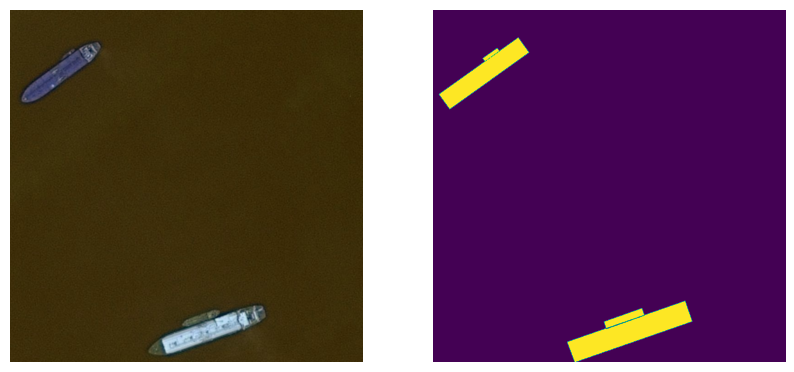

In [48]:
images = [image, mask]
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs = axs.flatten()

for ax, image in zip(axs, images):
    ax.imshow(image)
    ax.axis('off')